<a href="https://colab.research.google.com/github/Shujaat123/Noisy-AE-LSE/blob/main/Noisy_autoencoder_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noisy-AE-LSE: Noisy bypass-Autoencoder with Latent Space Encoding**

---



**Loading Useful libraries and packages**


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import random
!pip install wget
from random import sample

from os import path
import h5py
import keras.backend as K
import wget

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout, Conv2DTranspose, SeparableConv2D, Add
from keras.models import Model
from keras import backend as K
from tensorflow.keras import datasets, layers, losses

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=6f16f2ae234606f5b6e81b9b00bf715cd3d15836db619612952ea46bac4e3d37
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


**Loading dataset**

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 4s 0us/step


**Defining autoencoder(AE) model**

In [4]:
def my_model():
  input_img = Input(shape=(32, 32, 3))
  num_filter = 32
  kernel_size = 5
  strides = 1   
  
  x = Conv2D(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'enc1')(input_img)

  x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc2')(x) 
  x = AveragePooling2D((2, 2))(x)

  # x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  # x = AveragePooling2D((2, 2))(x)

  encoded = BatchNormalization()(x)
  

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec1')(x)

  # x = UpSampling2D((2,2), interpolation = 'bilinear')(x)
  # x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec2')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'dec4')(x)
  # x = BatchNormalization()(x)
  decoded = Conv2D(3, (1, 1), activation='relu', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
enc1 (Conv2D)                (None, 32, 32, 32)        2432      
_________________________________________________________________
enc2 (Conv2D)                (None, 32, 32, 3)         2403      
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 3)         0         
_________________________________________________________________
enc4 (Conv2D)                (None, 16, 16, 3)         228       
_________________________________________________________________
average_pooling2d_3 (Average (None, 8, 8, 3)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 3)           12  

**Training autoencoder(AE) model**

In [6]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

checkpoint = ModelCheckpoint('models\\model-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(train_images, train_images,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\model-best.h5')

Epoch 1/200
196/196 [==============================] - 53s 36ms/step - loss: 0.0928 - val_loss: 0.1098
Epoch 2/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0164 - val_loss: 0.0960
Epoch 3/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0142 - val_loss: 0.0424
Epoch 4/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 5/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0134 - val_loss: 0.0187
Epoch 6/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 7/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0129 - val_loss: 0.0154
Epoch 8/200
196/196 [==============================] - 6s 31ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 9/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0127 - val_loss: 0.0158
Epoch 10/200
196/196 [==============================] - 6s 30ms/step - loss: 0.01

**Testing autoencoder(AE) model**

In [7]:
predicted_test = autoencoder.predict(test_images[:100])
predicted_test = np.clip(predicted_test, 0., 1.)

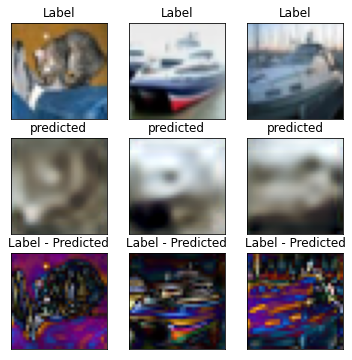

In [8]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
psnr_pred = tf.image.psnr(predicted_test, test_images[:100], max_val=1.0)
print('PSNR: ', np.mean(psnr_pred))

PSNR:  19.886082


**Analyzing Noise Characteristics of autoencoder(AE) model**

In [10]:
noise_factor_uniform = 0.4
noise_factor_normal = 0.25
noise_factor_speckle = 1.2

x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

In [11]:
predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

predicted_uniform = np.clip(predicted_uniform, 0., 1.)
predicted_normal = np.clip(predicted_normal, 0., 1.)
predicted_speckle = np.clip(predicted_speckle, 0., 1.)

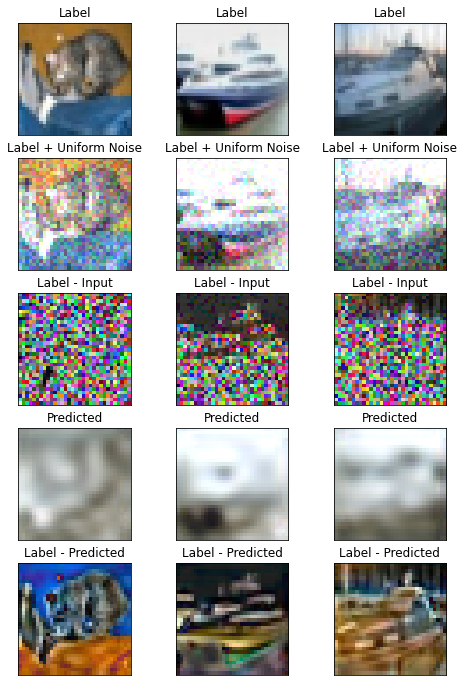

In [12]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Uniform Noise")
    plt.imshow(tf.squeeze((x_test_noisy_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_uniform[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_uniform[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

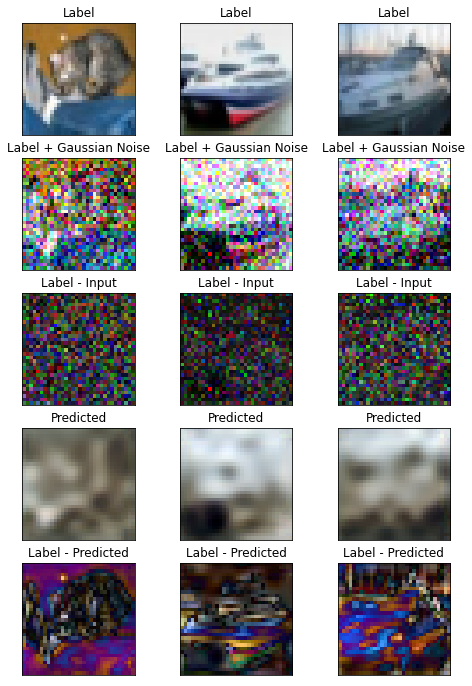

In [13]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Gaussian Noise")
    plt.imshow(tf.squeeze((x_test_noisy_normal[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_normal[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_normal[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_normal[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

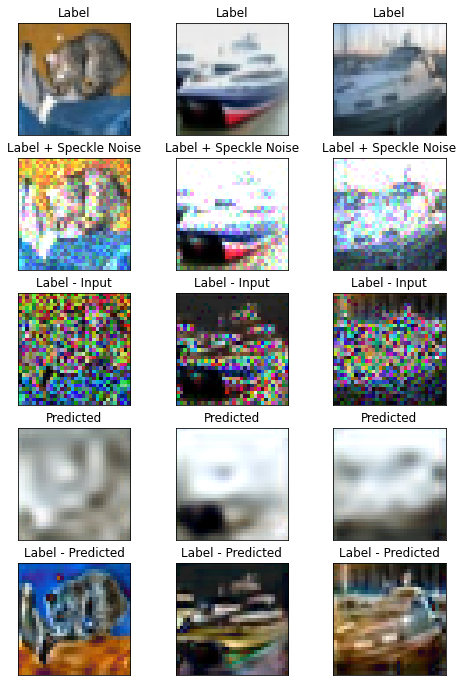

In [14]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Speckle Noise")
    plt.imshow(tf.squeeze((x_test_noisy_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_speckle[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_speckle[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [15]:
psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

Uniform:  13.486656 13.441136
Gaussian:  13.20172 18.98987
Speckle:  12.873505 12.93896


**Calculating Statistics for Noise Characteristics Curve of autoencoder(AE) model**

In [16]:
def calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder):
  x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
  x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
  x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


  x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
  x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
  x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

  predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
  predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
  predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

  predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  predicted_normal = np.clip(predicted_normal, 0., 1.)
  predicted_speckle = np.clip(predicted_speckle, 0., 1.)

  psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
  psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

  psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
  psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

  psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
  psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

  print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
  print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

  return np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred), np.mean(psnr_normal_input), np.mean(psnr_normal_pred), np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred)

In [17]:
# print('----')
# noise_factor_uniform = 0.74
# noise_factor_normal = 0.5
# noise_factor_speckle = 2.8
# calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder)
PSNR_Results = []
for i in range(0,20):
  noise_factor_uniform = i*0.04
  noise_factor_normal = i*0.025
  noise_factor_speckle = i*0.12
  PSNR_Results.append(calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

Uniform:  inf 19.88608
Gaussian:  inf 19.886084
Speckle:  inf 19.886084
----
Uniform:  32.85595 19.788305
Gaussian:  32.16248 19.875484
Speckle:  29.705439 19.544168
----
Uniform:  26.911463 19.356956
Gaussian:  26.198694 19.850452
Speckle:  24.091969 18.739143
----
Uniform:  23.453667 18.69749
Gaussian:  22.786753 19.814081
Speckle:  20.90613 17.768692
----
Uniform:  21.020615 17.91989
Gaussian:  20.365358 19.760117
Speckle:  18.778732 16.8519
----
Uniform:  19.139824 17.096878
Gaussian:  18.520218 19.673998
Speckle:  17.193562 15.98416
----
Uniform:  17.608425 16.278214
Gaussian:  17.046148 19.582878
Speckle:  15.947584 15.209186
----
Uniform:  16.34802 15.498699
Gaussian:  15.851437 19.460785
Speckle:  14.955144 14.5331
----
Uniform:  15.257895 14.770054
Gaussian:  14.839941 19.334303
Speckle:  14.138925 13.927921
----
Uniform:  14.308597 14.073889
Gaussian:  13.947718 19.196594
Speckle:  13.457758 13.403977
----
Uniform:  13.4801 13.435919
Gaussian:  13.194143 19.012749
Speckle:  1

In [18]:
from scipy.io import savemat

savemat('Noisy_AE_PSNR_Results.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("Noisy_AE_PSNR_Results.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>